In [1]:
import nltk
import string
import re
import sklearn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset in Google Drive
dataset_path = '/content/drive/My Drive/Colab Notebooks/urldata.csv'

# Read the dataset
data = pd.read_csv(dataset_path)
data.head()

Mounted at /content/drive


,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
4,icicibank.com,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0


In [3]:
data.shape

(10000, 18)

In [4]:
data.columns

Index(['Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth',
       'Redirection', 'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record',
       'Web_Traffic', 'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over',
       'Right_Click', 'Web_Forwards', 'Label'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         10000 non-null  object
 1   Have_IP        10000 non-null  int64 
 2   Have_At        10000 non-null  int64 
 3   URL_Length     10000 non-null  int64 
 4   URL_Depth      10000 non-null  int64 
 5   Redirection    10000 non-null  int64 
 6   https_Domain   10000 non-null  int64 
 7   TinyURL        10000 non-null  int64 
 8   Prefix/Suffix  10000 non-null  int64 
 9   DNS_Record     10000 non-null  int64 
 10  Web_Traffic    10000 non-null  int64 
 11  Domain_Age     10000 non-null  int64 
 12  Domain_End     10000 non-null  int64 
 13  iFrame         10000 non-null  int64 
 14  Mouse_Over     10000 non-null  int64 
 15  Right_Click    10000 non-null  int64 
 16  Web_Forwards   10000 non-null  int64 
 17  Label          10000 non-null  int64 
dtypes: int64(17), object(1)
mem

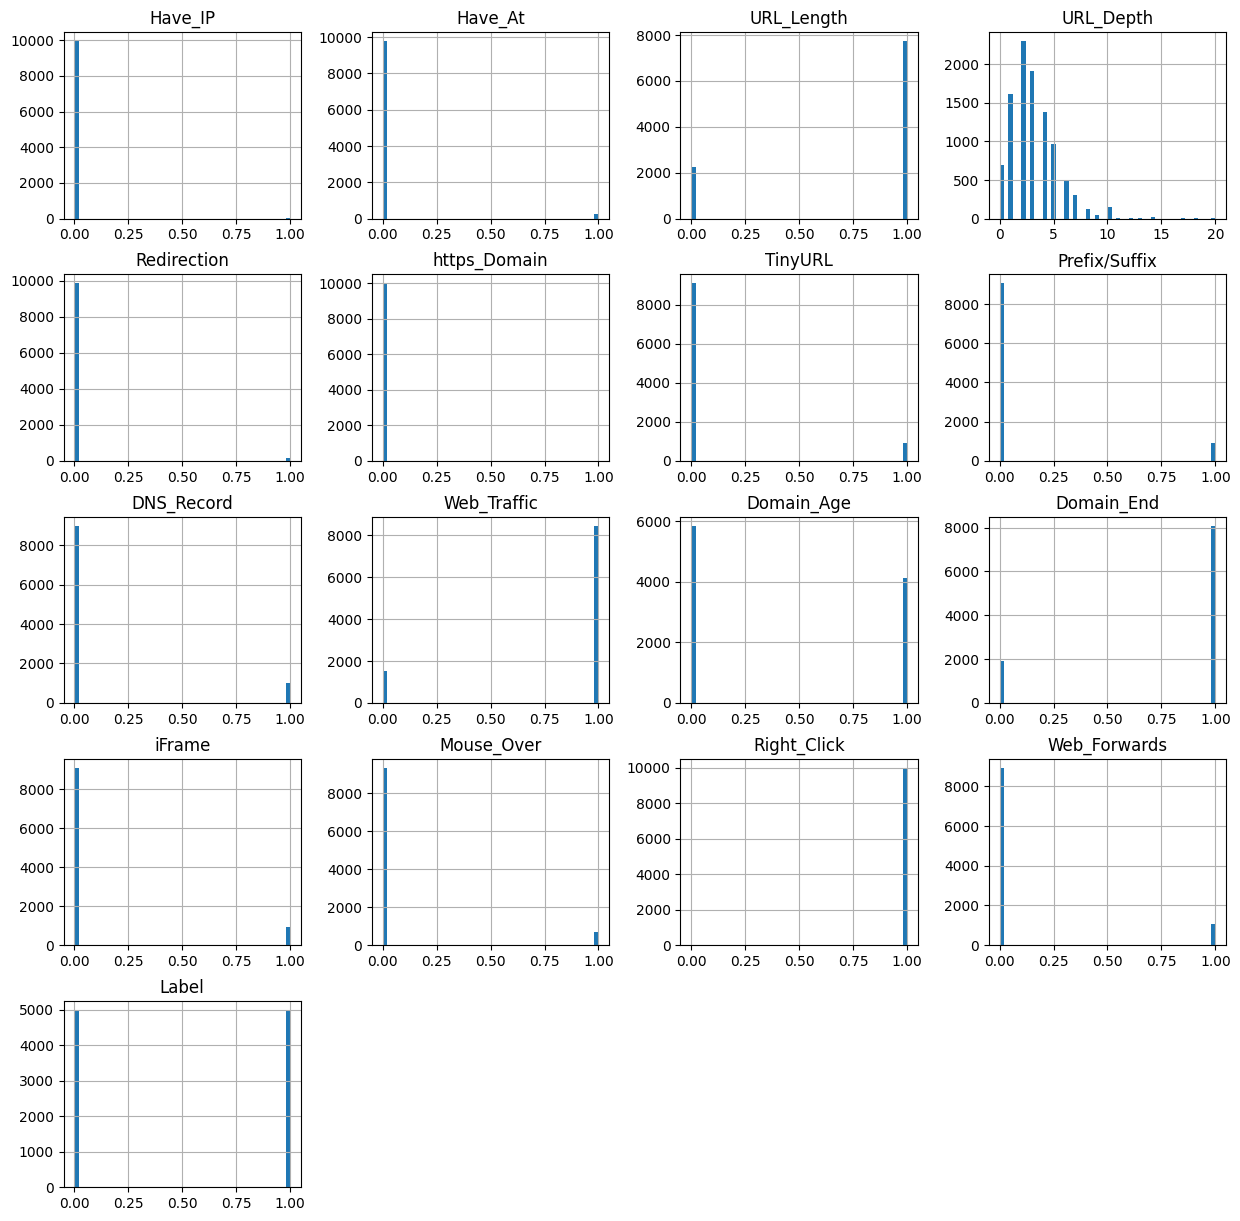

In [6]:
data.hist(bins = 50,figsize = (15,15))
plt.show()

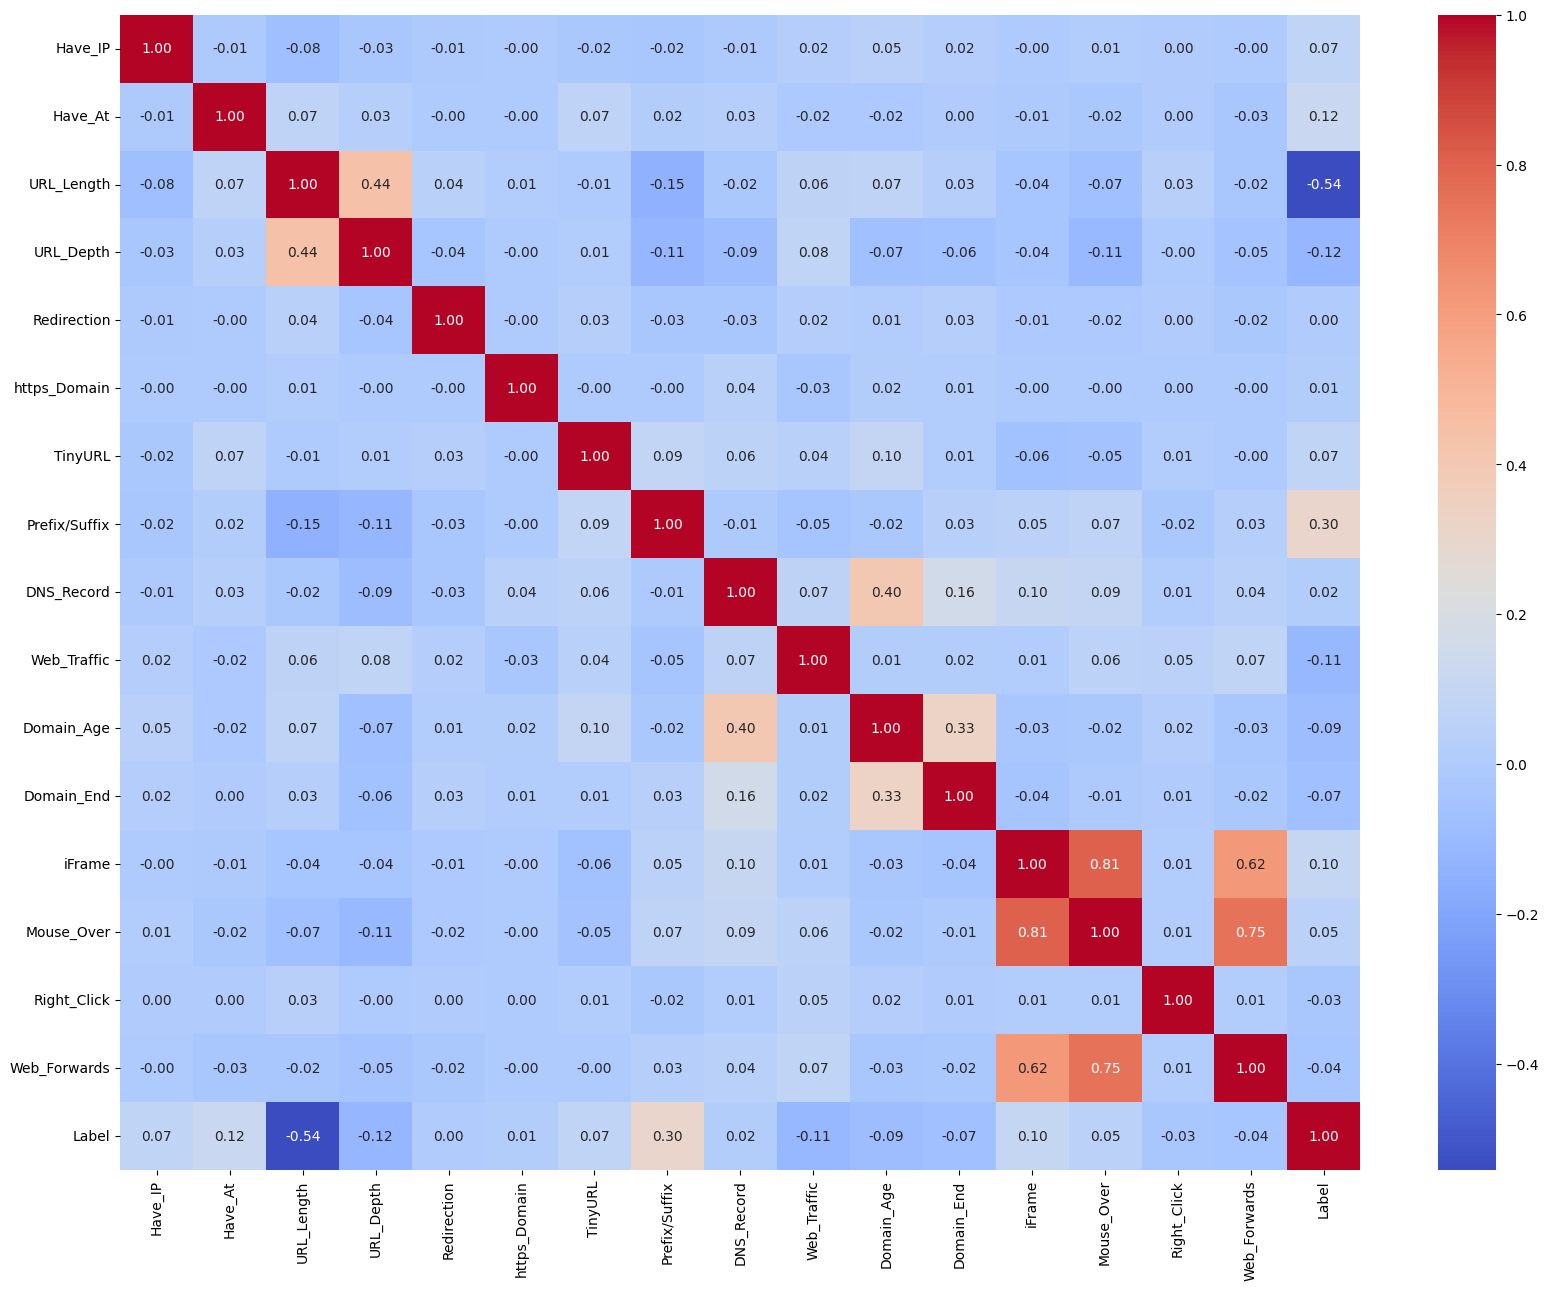

In [7]:
import seaborn as sns
# Convert categorical columns to numeric using one-hot encoding
categorical_cols = data.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Select only the numeric columns from the encoded DataFrame
numeric_data_encoded = data_encoded.select_dtypes(include=[np.number])

# Display the correlation matrix for the encoded DataFrame
correlation_matrix_encoded = numeric_data_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_encoded, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [8]:
data.describe()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000
mean,0.005500,0.022600,0.773400,3.072000,0.013500,0.000200,0.090300,0.093200,0.100800,0.845700,0.413700,0.8099,0.090900,0.06660,0.99930,0.105300,0.500000
std,0.073961,0.148632,0.418653,2.128631,0.115408,0.014141,0.286625,0.290727,0.301079,0.361254,0.492521,0.3924,0.287481,0.24934,0.02645,0.306955,0.500025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000,0.000000,0.00000,1.00000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000,0.000000,0.00000,1.00000,0.000000,0.500000
75%,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0000,0.000000,0.00000,1.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.00000,1.00000,1.000000,1.000000


In [9]:
#Dropping the Domain column
data1 = data.drop(['Domain'], axis = 1).copy()
data1.head()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0
1,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0
2,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
4,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0


In [10]:
#checking the data for null or missing values
data1.isnull().sum()

Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
DNS_Record       0
Web_Traffic      0
Domain_Age       0
Domain_End       0
iFrame           0
Mouse_Over       0
Right_Click      0
Web_Forwards     0
Label            0
dtype: int64

In [11]:
# shuffling the rows in the dataset so that when splitting the train and test set are equally distributed
data1 = data1.sample(frac=1).reset_index(drop=True)
data1.head()

,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,0,1,6,0,0,0,0,0,1,1,1,1,0,1,0,1
1,0,0,1,9,1,0,0,0,0,1,0,1,0,0,1,0,0
2,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
3,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,1,1
4,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1


In [12]:
#  !pip install optuna
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, BatchNormalization, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
#  import optuna

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Enforce deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Assuming your data is in a DataFrame named `data1`
# Separating & assigning features and target columns to X & y
y = data1['Label']
X = data1.drop('Label', axis=1)

# Split the dataset into train, validation, and test sets: 70-20-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Print shapes to verify
print("Train set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Test set shapes:", X_test.shape, y_test.shape)


Train set shapes: (7000, 16) (7000,)
Validation set shapes: (2000, 16) (2000,)
Test set shapes: (1000, 16) (1000,)


In [14]:

# Set random seeds for reproducibility in the final model
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Build and compile the final model with best parameters
model = Sequential([
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    LSTM(units=64, return_sequences=True),
    BatchNormalization(),
    Flatten(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Define a checkpoint callback to save the best model weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/weights2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 64)             0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 8, 64)             256       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 8, 64)             33024     
                                                                 
 batch_normalization_1 (Bat  (None, 8, 64)             256       
 chNormalization)                                                
                                                        

In [16]:
# Train the final model with the best parameters
history = model.fit(X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train,
                    epochs=28, batch_size=32, validation_data=(X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val),
                    verbose=0, callbacks=[model_checkpoint_callback])

# Load the best model weights
model.load_weights(checkpoint_filepath)

In [17]:
# Evaluate the final model
loss, accuracy = model.evaluate(X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

32/32 [==============================] - 0s 6ms/step - loss: 0.3056 - accuracy: 0.8880
Test Loss: 0.3055671453475952
Test Accuracy: 0.8880000114440918
